### importar librerias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import gc

### Leer datasets

Dataset con datos etiquetados

In [3]:
df = pd.read_csv("Dataset_etiquetado.csv")

In [4]:
df.head()

,id_trn_ach,id_cliente,fecha,hora,valor_trx,etiqueta
0,241307506,19,20170210.0,142809,701067.98,1
1,359125394,35,20180808.0,122953,246964.14,1
2,285847659,40,20171003.0,151703,192491.73,1
3,319249942,45,20180305.0,111143,49520.98,1
4,335337578,45,20180507.0,145248,431146.54,1


Dataset dt_info_pagadores_muestra

In [5]:
pagadores=pd.read_csv('dt_info_pagadores_muestra.csv', error_bad_lines=False,warn_bad_lines=False, header= None)
pagadores=pagadores.rename(columns={0:"id_cliente",1:"seg_str",2:"ocupacion",
                  3:"tipo_vivienda",4:"nivel_academico",5:"estado_civil",6:"genero",
                  7:"edad",8:"ingreso_rango",})
print (pagadores.shape)

(338606, 9)


In [6]:
meta_data=pd.read_excel('Metadatos_Tabla.xlsx')
meta_data

,name,type,comment
0,id_cliente,bigint,NaN
1,seg_str,string,NaN
2,ocupacion,string,NaN
3,tipo_vivienda,string,NaN
4,nivel_academico,string,NaN
5,estado_civil,string,NaN
6,genero,string,NaN
7,edad,int,NaN
8,ingreso_rango,string,NaN


### Filtrado de Datos

Se eliminan los registros  de clientes sin información en la edad, y se remplazan valores que no están proporcionados en el diccionario suministrado por BC

In [8]:
pagadores= pagadores[pagadores.edad != '\\N']
pagadores.edad= pagadores['edad'].astype(int)
pagadores.ocupacion= pagadores.ocupacion.replace('0',"O")
pagadores.tipo_vivienda=pagadores.tipo_vivienda.replace(["1","2","3","4"],np.nan)#se remplaza descripciones no dadas en la guia
pagadores.ingreso_rango=pagadores.ingreso_rango.replace(['No disponible',"0"],np.nan)#se remplaza descripciones no dadas en la guia



### Analisis outlayers edades

Se eliminan las edades atípicas o datos erróneos como negativos o extremos, según un análisis de outliers determinado por Isolation Forest   

In [9]:
isolation_forest = IsolationForest(n_estimators=100,contamination =0.01)
isolation_forest.fit(pagadores.edad.values.reshape(-1, 1))
x = np.linspace(-5, 100, 1000).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(x)
outlier = isolation_forest.predict(x)


C:\Users\lssro\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\lssro\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


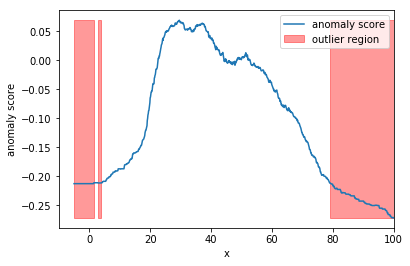

In [10]:
plt.plot(x, anomaly_score, label='anomaly score')
plt.fill_between(x.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('x')
plt.xlim([-10, 100])
plt.show()

In [11]:
min(x[outlier==1])

array([1.51651652])

In [12]:
max(x[outlier==1])

array([79.08408408])

In [13]:
pagadores= pagadores[(pagadores.edad >= 10)&(pagadores.edad <= 8)]

Muestras resultado eliminacion de edades poco frecuentes

In [14]:
pagadores.head()

,id_cliente,seg_str,ocupacion,tipo_vivienda,nivel_academico,estado_civil,genero,edad,ingreso_rango
1,32,PERSONAL PLUS,E,F,T,M,M,80,i. (8.7 Inf)
4,71,PERSONAL,5,O,S,M,M,79,e. (4.4 5.5MM]
5,72,PERSONAL,1,O,U,M,M,74,b. (1.1 2.2MM]
7,108,PERSONAL PLUS,1,O,U,M,F,37,f. (5.5 6.6MM]
8,210,EMPRENDEDOR,3,NaN,U,M,M,34,i. (8.7 Inf)


### Verificacion categorias por columna

En tipo de vivienda, en ningun registro se encuentra la categoria A y P ademas se encuentran catergorias adicionales como 1,2,3 y 4  que no estan en el diccionario de datos suministrado por BC, tambien se encuentran valores nan que se tomaran como valores no disponibles


In [16]:
columna=pagadores.ingreso_rango
dic_ocupacion = dict(zip(columna.unique(),np.linspace(1,len(columna.unique()),len(columna.unique()))))
dic_ocupacion

{'i. (8.7  Inf)': 1.0,
 'e. (4.4  5.5MM]': 2.0,
 'b. (1.1  2.2MM]': 3.0,
 'f. (5.5  6.6MM]': 4.0,
 'h. (7.6  8.7MM]': 5.0,
 'g. (6.6  7.6MM]': 6.0,
 'c. (2.2  3.3MM]': 7.0,
 'd. (3.3  4.4MM]': 8.0,
 'a. (0  1.1MM]': 9.0,
 nan: 10.0}

### One hot encoding  dataset pagadores

se realiza un one hot encoding de las clases categóricas del dataset pagadores

In [17]:
pagadores=pd.get_dummies(pagadores, columns=["seg_str",'ocupacion',"genero","edad","ingreso_rango","tipo_vivienda","estado_civil","nivel_academico"])

### Consolidacion dataset pagadores y transacciones

In [18]:
Consolidado=pagadores.join(df.set_index('id_cliente'), on='id_cliente')

Eliminación de columnas que ya no son necesarias, y limpieza de registros que no estaban en ambas tablas

In [19]:
del Consolidado["id_cliente"]
del Consolidado["id_trn_ach"]


Consolidado=Consolidado[Consolidado.etiqueta.notna()]
Consolidado=Consolidado.reset_index(drop=True)

muestra

In [20]:
Consolidado.head()

,seg_str_EMPRENDEDOR,seg_str_OTRO,seg_str_PERSONAL,seg_str_PERSONAL PLUS,seg_str_PREFERENCIAL,ocupacion_1,ocupacion_2,ocupacion_3,ocupacion_4,ocupacion_5,...,nivel_academico_I,nivel_academico_N,nivel_academico_P,nivel_academico_S,nivel_academico_T,nivel_academico_U,fecha,hora,valor_trx,etiqueta
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,20171009.0,90609.0,15100.91,1.0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,20171013.0,101444.0,157299.02,2.0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,20170825.0,175028.0,371718.55,2.0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,20180124.0,104113.0,382742.66,2.0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,20180325.0,153255.0,125253.38,2.0


### Analisis outlayers valor transacciones

Inicialmente se eliminan las transacciones que son menores o iguales a 0 pesos.

Se eliminan las transacciones poco, anormales o poco frecuentes en cuanto a valor de transaccion

In [21]:
Consolidado=Consolidado[Consolidado.valor_trx>0]#                      <=99000000]

In [22]:
isolation_forest = IsolationForest(n_estimators=100,contamination =0.01)
isolation_forest.fit(Consolidado.valor_trx.values.reshape(-1, 1))
x = np.linspace(-100, 100000000, 10000).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(x)
outlier = isolation_forest.predict(x)

C:\Users\lssro\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\lssro\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


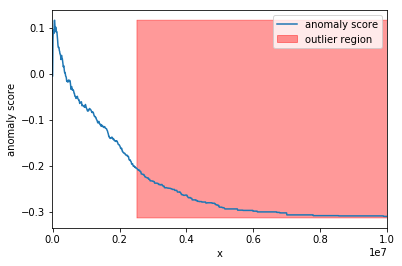

In [23]:
plt.plot(x, anomaly_score, label='anomaly score')
plt.fill_between(x.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('x')
plt.xlim([-5000, 9999999])
plt.show()

In [24]:
max(x[outlier==1])

array([2510153.53535354])

se eliminaran 1738 de transacciones, estas se definen como transacciones atipicas menos del 0.01%

In [25]:
Consolidado=Consolidado[Consolidado.valor_trx<=10000000]

In [26]:
Consolidado.shape

(3197091, 127)

Guardado del dataset

In [27]:
Consolidado.to_csv("Dataset_consolidado.csv",index=False)